In [1]:
# 한글폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,731 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120500 files and dire

In [2]:
# konlpy 설치
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 15.3 MB/s eta 0:00:00


In [3]:
# 라이브러리 불러오기
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 데이터 불러오기

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
path = '/content/drive/MyDrive/0.광주인공지능사관학교/PROJECT'
train_data = pd.read_table(path+'/train_DB_v3_5labels.txt', encoding='utf-8', header=None, names = ['text', 'label'])
test_data = pd.read_table(path+'/testDB_5labels.txt', encoding='utf-8', header=None, names = ['text', 'label'])

In [60]:
display(train_data.head())
display(test_data.head())

,text,label
0,이 스피커 정말 좋다 베이스가 장난 아닌데 그치 오랜만에 돈 좀 들여서 장만했다 역...,0.0
1,여기 주짓수 학원이죠 뭐 좀 여쭙겠습니다 예 수강하시게요 네 선생님은 유단자인가요 ...,1.0
2,아 그렇겠다 어 그게 또 안 좋구나 응 그렇지 그래두 오빠 사람 많은데 잘 가잖아 ...,0.0
3,일찍부터 반태 어승 일찍 아저씨가 됐어 그리고 어승은 근데 입학할 때부터 여기 고기...,0.0
4,매운거 땡긴다 엽떡 먹으러 가자 아나는 매운거 잘 못먹는데 매운거 먹고 싶어 응 거...,0.0


,text,label
0,문서파일 가져오고 집에 가서 가져와 저는 지난 일주일간의 출입자목록 작성해서 내일까...,NaN
1,간다 언제까지 자신으로부터 20거야 언제까지 무장도 안하고 이렇게 빙결동안 기다릴 ...,NaN
2,없어 여태 찾아봤다니까 아니 되게 장일주일 남겨놓고 왜 또 그러는 거야 그렇게 불안...,NaN
3,따뜻해 근데 자기는 톡 옛날 애인도 얘기는 안하더라 첫날밤이니까 애인이 바뀔 때마다...,NaN
4,결혼하지 말까봐 잡았는데 별로야 병원 차릴 비용이라도 달래 그 사람 왼쪽 눈밑에 사...,NaN


In [61]:
train_label_nan = train_data[train_data['label'].isnull()]
train_label_nan.head()

,text,label
74,야 yellow mon key 지금 저한테 그러시는 거에요 그럼 지금 여기에 이렇게...,NaN
84,네 한국대학교 시설과입니다 아 저 교내 학생인데 공대 건물 화장실에 물이 죄다 안나...,NaN
104,나무 엄청 크다 이런 나무 한 번도 본 적 없는데 재밌다 우리 이거 부러뜨려볼까 근...,NaN
171,야 나 민지랑 잤다 지랄하네 민지 남자친구 있잖아 어 근데 민지가 나 좋아한다고 먼...,NaN
192,어머 선생님 창선이 무릎이 왜 이래요 아 오늘 창선이가 놀이터에서 놀다가 살짝 긁혔...,NaN


In [62]:
# train_data 중에서 label 열이 nan인 행 확인 -> 문장 마지막이 공백 + 카테고리 로 구성되어 있음. -> 공백은 지우고, 카테고리를 label 컬럼에 넣는 작업 필요
for i in range(5):
    print(train_label_nan['text'].iloc[i])
    print()

야 yellow mon key 지금 저한테 그러시는 거에요 그럼 지금 여기에 이렇게 눈 찢어진 사람이 누가 있어 기분 나쁘니까 그런 말 하지 마세요 쿨하지 못하네 넌 어디 출신인데 중국 일본 한국 출신이거든요 한국 그런 나라가 있어 오호 BTS 모르세요 아 그 나라야 너무 조그만해서 있는지도 몰랐어 그럼 여행 잘해 grumpy monkey 1

네 한국대학교 시설과입니다 아 저 교내 학생인데 공대 건물 화장실에 물이 죄다 안나와서요 어떤 물 말씀하세요 그냥 수돗물이나 변기물 다 안나와요 아 그러면 우선 접수 해드릴 테니까 처리되는 대로 가서 확인하고 문제 보완할게요 그러면 얼마나 걸릴까요 거의 일주일은 걸릴 거 같아요 아니 그럼 그 동안 화장실은 사용하지 말라는 거에요 저희도 처리할 업무들이 많아서요 바로바로 처리 해드리기는 조금 어려울 듯 해요 아니 아무리 봐도 시설과에서 뭘 하는 걸 본적이 없는데 그게 무슨 개떡같은 소리야 비싼 등록금 내고 학교 다니는데 이딴 식으로 일처리 할거면 그냥 때려치든가 행정업무를 무슨 굼벵이들이 하나 1

나무 엄청 크다 이런 나무 한 번도 본 적 없는데 재밌다 우리 이거 부러뜨려볼까 근데 이거 다른 사람 소유물일 수도 있잖아 우리가 이거 부숴버리면 경찰에 신고 당하는 거 아니야 아니야 내가 알아봤는데 이거 그냥 땔감이야 땔감이면 그 사람이 찾고 있는 거 아니야 아니야 사실 여기 우리 아빠 별장이야 괜찮아 신경 쓸 거 없어 야 왜 말 안 했어 진작 부숴버릴 걸 0

야 나 민지랑 잤다 지랄하네 민지 남자친구 있잖아 어 근데 민지가 나 좋아한다고 먼저 고백하고 나 벽에 밀치고 키스했다니까 그래서 바로 텔 가서 떡쳤지 미친 민지한테 물어봐도 되는 거냐 뭘 물어봐 사실인데 진심이라니까 그년 젖꼭지 색깔도 알아 내가 무슨 색깔인데 핑크색 오늘도 자자고 할라고 1

어머 선생님 창선이 무릎이 왜 이래요 아 오늘 창선이가 놀이터에서 놀다가 살짝 긁혔어요 저도 놀라서 봤는데 다행히 크게 다치진 않았고 살짝 까졌더라구요 연고랑 밴드 붙여뒀고 

In [63]:
train_data['label'].value_counts()

0.0    5549
4.0    1398
2.0    1040
1.0     828
3.0     501
Name: label, dtype: int64

# 2. 데이터 전처리

## label 컬럼 채우기

In [64]:
list1 = []
def sep_category(data):
    for i in range(len(data)):
        res = data['text'][i][-1] # 카테고리

        # text에 붙어있는 카테고리 분할, null 값에 넣어주기
        if res in ('0', '1', '2', '3', '4'):
            list1.append(res)
            data['label'][i] = res # label 열에 추가
            data['text'][i] = data['text'][i][:-2] # 공백 + 카테고리 지우기

        elif res == ' ':
            data['text'][i] = data['text'][i][:-1]

In [65]:
sep_category(train_data)
sep_category(test_data)

<ipython-input-64-1c5d78aae2cd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'][i] = data['text'][i][:-1]
<ipython-input-64-1c5d78aae2cd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'][i] = res # label 열에 추가


In [66]:
print(train_data['label'].value_counts())
print()
print(test_data['label'].value_counts())

0.0    5549
4.0    1398
2.0    1040
1.0     828
3.0     501
1        92
0        34
4        15
3         2
2         2
Name: label, dtype: int64

0    58
2    14
3    10
4     8
1     6
Name: label, dtype: int64


In [67]:
# 카테고리 null값 없는 거 확인
print(train_data.isnull().sum())
print()
print(test_data.isnull().sum())

text     0
label    0
dtype: int64

text     0
label    0
dtype: int64


In [68]:
#  train_data 의 label을 1.0, 0.0 형태(float)에서 -> 1, 0 형태(str)로 바꿔주기(test_data와 통일하기 위해서)
train_data['label'] = train_data['label'].apply(lambda x:str(int(x)))

## 이진분류 준비.
- label의 values를 비폭력(0), 폭력(1)으로 바꿔줌

In [69]:
# 이진분류를 위해 label 을 0, 1로 변경(비폭력 0, 폭력 1)
# https://tariat.tistory.com/622

train_data['label'] = train_data['label'].apply(lambda x: str(1) if x != str(0) else x)
test_data['label'] = test_data['label'].apply(lambda x: str(1) if x != str(0) else x)

In [70]:
print(train_data['label'].value_counts())
print()
print(test_data['label'].value_counts())

0    5583
1    3878
Name: label, dtype: int64

0    58
1    38
Name: label, dtype: int64


In [71]:
# 데이터 중복 확인하기
print(len(train_data))
print(train_data['text'].nunique())

9461
9442


In [72]:
# 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['text'], inplace=True)
print(len(train_data))

9442


<Axes: >

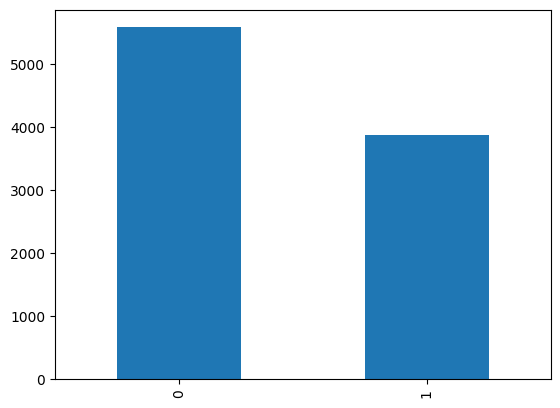

In [73]:
train_data['label'].value_counts().plot(kind='bar')

In [74]:
# null 값 확인 -> 없음
train_data.isnull().sum()

text     0
label    0
dtype: int64

## 토큰화 & 불용어 제거

In [84]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [85]:
X_train = []
okt = Okt()
for sentence in tqdm(train_data['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 9442/9442 [03:05<00:00, 50.92it/s]


In [86]:
X_test = []
for sentence in tqdm(test_data['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 96/96 [00:01<00:00, 67.65it/s]


## 정수 인코딩

In [87]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [88]:
print(tokenizer.word_index)

{'그렇다': 1, '있다': 2, '거': 3, '아니다': 4, '아': 5, '을': 6, '보다': 7, '너': 8, '안': 9, '내': 10, '요': 11, '나': 12, '야': 13, '네': 14, '같다': 15, '뭐': 16, '말': 17, '것': 18, '없다': 19, '다': 20, '진짜': 21, '알다': 22, '가다': 23, '되다': 24, '왜': 25, '그': 26, '먹다': 27, '저': 28, '게': 29, '오다': 30, '좋다': 31, '못': 32, '만': 33, '맞다': 34, '로': 35, '자다': 36, '너무': 37, '고': 38, '에서': 39, '지금': 40, '돼다': 41, '그냥': 42, '사람': 43, '우리': 44, '어떻다': 45, '해': 46, '님': 47, '싶다': 48, '제': 49, '들다': 50, '거야': 51, '이야': 52, '응': 53, '나다': 54, '어': 55, '무슨': 56, '죄송하다': 57, '더': 58, '않다': 59, '여기': 60, '수': 61, '때': 62, '모르다': 63, '죽다': 64, '예': 65, '한테': 66, '일': 67, '새끼': 68, '정말': 69, '오늘': 70, '돈': 71, '이다': 72, '집': 73, '근데': 74, '그렇게': 75, '많이': 76, '버리다': 77, '생각': 78, '나오다': 79, '해주다': 80, '니': 81, '랑': 82, '알': 83, '하고': 84, '주다': 85, '까지': 86, '이렇다': 87, '니까': 88, '건': 89, '많다': 90, '받다': 91, '줄': 92, '걸': 93, '면': 94, '이렇게': 95, '하': 96, '지': 97, '씨': 98, '인데': 99, '하나': 100, '괜찮다': 101, '같이': 102, '시간': 103, '그게':

In [89]:
# 빈도수 낮은 단어 확인
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 21647
등장 빈도가 2번 이하인 희귀 단어의 수: 10932
단어 집합에서 희귀 단어의 비율: 50.501224188109205
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8894762313971587


In [90]:
# 등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지합니다.
# 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.87%밖에 되지 않습니다.
# 아무래도 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

In [91]:
# 전체 단어 개수 중 빈도수 2 이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 10716


In [92]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [93]:
print(X_train[:3])

[[3928, 69, 31, 3722, 284, 4, 447, 649, 33, 71, 639, 2659, 455, 1506, 615, 599, 74, 363, 269, 3723, 30, 104, 3, 32, 24, 3, 30, 2577, 84, 95, 41, 16, 13, 1, 45, 41, 4, 831, 6, 36, 208, 5240, 20, 840, 30, 3, 409, 7, 736, 21, 9, 9, 273, 95, 86, 840, 427, 2, 184, 9, 1, 2093, 814, 616, 99, 2577, 84, 1461, 1462, 86, 21, 612, 26, 840, 3, 850, 108, 1139, 91, 1139, 2891, 3, 2, 42, 5241, 86, 2389, 35, 2577, 91], [60, 5242, 429, 117, 16, 1554, 65, 3163, 14, 221, 562, 65, 5, 14, 1, 138, 138, 851, 246, 715, 65, 4, 221, 138, 138, 851, 246, 715, 104, 56, 221, 7718, 117, 5242, 7719, 39, 623, 32, 1753, 676, 2, 284, 1733, 193, 488, 987, 6815, 3304, 3424, 6177, 2, 242, 72, 49, 221, 8958, 89, 151, 650, 41, 331, 5242, 2968, 3572, 7720, 251, 1, 6, 967, 558, 26, 954, 26, 997, 150, 51, 17, 1463, 118, 1, 769, 1463, 988, 6816, 72, 42, 429, 9, 159, 20, 1636, 37, 895, 19], [5, 1, 55, 104, 106, 9, 31, 53, 1, 1, 370, 43, 90, 36, 23, 55, 658, 804, 59, 55, 1, 55, 124, 2728, 59, 4353, 91, 89, 124, 2728, 87, 1669, 2728

In [94]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [95]:
# 빈 샘플 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [96]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

9441
9441


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


text의 최대 길이 : 714
text의 평균 길이 : 77.51583518695054


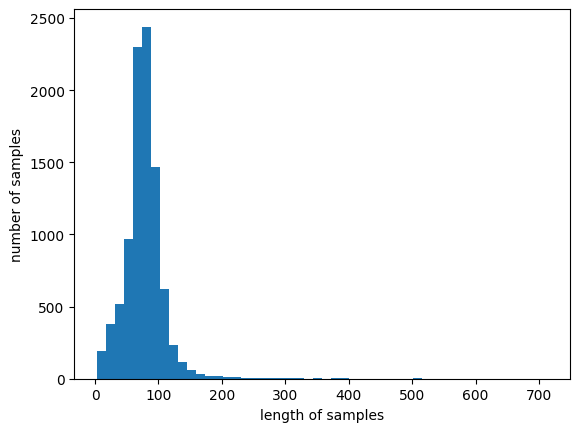

In [97]:
# 패딩
print('text의 최대 길이 :',max(len(l) for l in X_train))
print('text의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [98]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [99]:
max_len = 120
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 120 이하인 샘플의 비율: 95.13822688274547


In [100]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 모델 학습

In [101]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [104]:
# LSTM 모델 학습

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

In [105]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [120]:
start = time.time()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train.astype(int), epochs=30, callbacks=[es, mc], batch_size=64, validation_split=0.2)
end = time.time()
print(f'실행시간 {(end - start)//60}')

Epoch 1/30
118/118 [==============================] - ETA: 0s - loss: 0.0246 - acc: 0.9926
Epoch 1: val_acc improved from 0.95447 to 0.95500, saving model to best_model.h5
118/118 [==============================] - 39s 299ms/step - loss: 0.0246 - acc: 0.9926 - val_loss: 0.1490 - val_acc: 0.9550
Epoch 2/30
118/118 [==============================] - ETA: 0s - loss: 0.0172 - acc: 0.9947
Epoch 2: val_acc did not improve from 0.95500
118/118 [==============================] - 40s 343ms/step - loss: 0.0172 - acc: 0.9947 - val_loss: 0.1662 - val_acc: 0.9539
Epoch 3/30
118/118 [==============================] - ETA: 0s - loss: 0.0142 - acc: 0.9963
Epoch 3: val_acc did not improve from 0.95500
118/118 [==============================] - 33s 283ms/step - loss: 0.0142 - acc: 0.9963 - val_loss: 0.1750 - val_acc: 0.9518
Epoch 4/30
118/118 [==============================] - ETA: 0s - loss: 0.0124 - acc: 0.9980
Epoch 4: val_acc did not improve from 0.95500
118/118 [==============================] - 33

In [122]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test.astype(int))[1]))

3/3 [==============================] - 1s 108ms/step - loss: 0.7216 - acc: 0.8646

 테스트 정확도: 0.8646


# 모델 테스트

In [123]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 폭력상황입니다.\n".format(score * 100)) # 폭력 1
  else:
    print("{:.2f}% 확률로 비폭력상황입니다.\n".format((1 - score) * 100)) # 비폭력 0

In [124]:
sentiment_predict('거기 누구세요 뭐야 누가 왔어 누군데 그러냐 저기 오늘 같이 와주셔서 즐거웠어요 지도 않고 뭐 어디 가서 차나 한잔 할 얘기도 있고요')

1/1 [==============================] - 0s 466ms/step
61.43% 확률로 비폭력상황입니다.



In [ ]:
sentiment_predict('김과장 그거 밖에 못하는 거는 처장님 무슨 일 때문에 그러시는 건지 이런 식으로 하는 거야말로 하는 거야 어떻게 하는 놈이 데리고 다니는 거 같아 잠깐 하던 거 멈춰 이리 와봐 김과장 믿음이 촬영 결과 한번 봐봐 이게 뭘 많이 있는 놈이 철원군 청아리야 과장이란 놈이 대리한테 지적질 한다고')

98.54% 확률로 폭력상황입니다.



In [125]:
sentiment_predict('너 제대로 안해 과장님 게임하는데 제가 뭘 어쨌는데 네가 먼저 치고 나가는 바람에 지금 말하잖아 말 좀 하라고 과장님도 알고 있는 줄 알았죠 맘대로 하지 말고 네 알겠습니다 그러면 오늘은 제대로 해보자고 집에서 게임 들어와 들어올 때 연락주고 네 알겠습니다')

1/1 [==============================] - 0s 54ms/step
100.00% 확률로 폭력상황입니다.



In [126]:
sentiment_predict('이 목걸이 진짜 예쁘지 않아 완전 사고 싶어 진짜 디자인 죽이네 어디꺼야 내가 맨날 사고 싶다하던 브랜드야 그럼 사지 왜 안사 저거 샀다가는 카드값막느라 내 허리가 부러지겠어 얼마길래 200만원이래 이번 달은 불가능이야 눈곱만한 다이아라도 붙은거야 진짜 비싸다 그치 근데 너무 이뻐서 고민 되는거 있지')

1/1 [==============================] - 0s 28ms/step
100.00% 확률로 비폭력상황입니다.



In [140]:
sentiment_predict('야 씨발놈아 개새끼야 죽을래 쳐맞을래')

1/1 [==============================] - 0s 64ms/step
89.49% 확률로 폭력상황입니다.



In [141]:
sentiment_predict('아아아 나 진짜 발목발목 왜 그러는데 넘어진거야 뭐야 괜찮아 아 진짜 아파발목 돌아갔어 괜찮은거야 어디 부러진거 아냐 잘 봐봐 얼른 모르겠어 잠깐 쉬었다가 잡아줘봐 아니 어쩌다가 그런건데 병원 가야하는거 아니냐 스텝밟는거 연습하다가 잠깐 사이에 확 너 진짜 괜찮음 곧 대회인데 몸관리 안하면 혼난다고 파스 가져다 뿌려줘 아까는 부러진것 처럼 아팠는데 지금 좀 괜찮은 것 같아')

1/1 [==============================] - 0s 29ms/step
99.97% 확률로 비폭력상황입니다.

